In [ ]:
# prompt: take datser from kaggle

!pip install kaggle
from google.colab import files
files.upload() # upload kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tapakah68/supervisely-filtered-segmentation-person-dataset
# replace <dataset-name> with the name of the dataset you want to download

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tapakah68/supervisely-filtered-segmentation-person-dataset
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 4.29G/4.31G [00:58<00:00, 94.9MB/s]
100% 4.31G/4.31G [00:58<00:00, 78.5MB/s]


In [ ]:
!unzip supervisely-filtered-segmentation-person-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_person-human-female-girl.png  
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_person-woman-coffee-cup.png  
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_person-woman-eyes-face.png  
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_person-woman-hotel-laptop.png  
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_pexels-photo-105472.png  
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_pexels-photo-123318.png  
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_pexels-photo-125522.png  
  inflating: supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds2_pexels-photo-

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('/content/df.csv')

In [ ]:
df.head()

Unnamed: 0                               images  \
0           0  images/ds10_pexels-photo-687782.png   
1           1  images/ds10_pexels-photo-835971.png   
2           2  images/ds10_pexels-photo-850708.png   
3           3  images/ds10_pexels-photo-864937.png   
4           4  images/ds10_pexels-photo-865908.png   

                                masks                              collages  
0  masks/ds10_pexels-photo-687782.png  collage/ds10_pexels-photo-687782.jpg  
1  masks/ds10_pexels-photo-835971.png  collage/ds10_pexels-photo-835971.jpg  
2  masks/ds10_pexels-photo-850708.png  collage/ds10_pexels-photo-850708.jpg  
3  masks/ds10_pexels-photo-864937.png  collage/ds10_pexels-photo-864937.jpg  
4  masks/ds10_pexels-photo-865908.png  collage/ds10_pexels-photo-865908.jpg

In [ ]:
import pandas as pd
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [ ]:
def load_data(img_folder,mask_folder,img_size=(256,256)):
  images=[]
  masks=[]
  for img_name in os.listdir(img_folder):
    img_path=os.path.join(img_folder,img_name)
    mask_path=os.path.join(mask_folder,img_name)
    img=load_img(img_path,target_size=img_size,color_mode='grayscale')
    mask=load_img(mask_path,target_size=img_size,color_mode='grayscale')
    img=img_to_array(img)
    mask=img_to_array(mask)
    img=img/255.0
    mask=mask/255.0
    images.append(img)
    masks.append(mask)

  images=np.array(images)
  masks=np.array(masks)
  return images,masks


In [ ]:
img_folder='/content/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images'
mask_folder='/content/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/masks'
img_size=(256,256)
images,masks=load_data(img_folder,mask_folder,img_size)

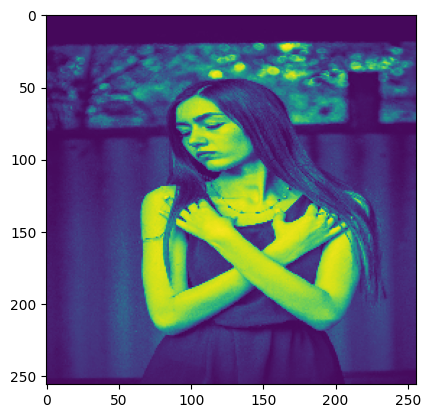

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[0])

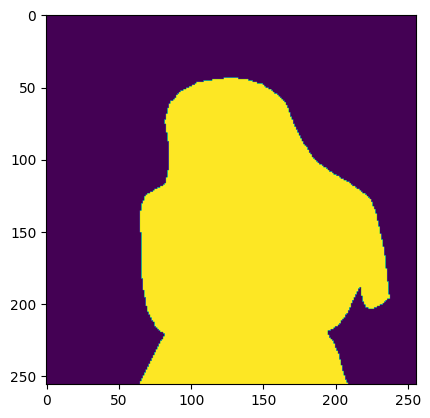

In [ ]:
plt.imshow(masks[0])

In [ ]:
X_train,x_test,y_train,y_test=train_test_split(images,masks,test_size=0.2,random_state=42)

In [ ]:
X_train[0].shape

(256, 256, 1)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize


def unet_model(input_size=(256, 256, 1)):
    inputs = tf.keras.layers.Input(input_size)
    # Encoding path
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = tf.keras.layers.concatenate([conv4, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=Adam(learning_rate=1e-5, clipvalue=1.0), loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = unet_model()

In [ ]:
results = model.fit(X_train, y_train, validation_data=(x_test, y_test), batch_size=16, epochs=20)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.6804 - loss: 0.6931 - val_accuracy: 0.6745 - val_loss: 0.6929
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 115s 851ms/step - accuracy: 0.6920 - loss: 0.6928 - val_accuracy: 0.6773 - val_loss: 0.6925
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 140s 834ms/step - accuracy: 0.6943 - loss: 0.6924 - val_accuracy: 0.6989 - val_loss: 0.6911
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 142s 834ms/step - accuracy: 0.7055 - loss: 0.6899 - val_accuracy: 0.7029 - val_loss: 0.6788
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 142s 832ms/step - accuracy: 0.7387 - loss: 0.6772 - val_accuracy: 0.7512 - val_loss: 0.6637
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 145s 855ms/step - accuracy: 0.7714 - loss: 0.6616 - val_accuracy: 0.7699 - val_loss: 0.6565
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 142s 855ms/step - accuracy: 0.7929 - loss: 0.6555 - val_accuracy: 0.7867 - val_loss: 0.6483
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 139s 835ms/step - accuracy: 0.7987 - lo

In [ ]:
model.save('unet_model.h5')

In [ ]:
# prompt: Load model

from tensorflow.keras.models import load_model
loaded_model = load_model('unet_model.h5')


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'unet_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)